# GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Tue Jan 19 09:27:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# CFG

In [2]:
CONFIG_NAME = 'config18.yml'

from requests import get
filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
TITLE = filename.split('.')[0]

In [3]:
! rm -r cassava

rm: cannot remove 'cassava': No such file or directory


In [4]:
! git clone https://github.com/raijin0704/cassava.git
# ====================================================
# CFG
# ====================================================
import yaml

CONFIG_PATH = f'./cassava/config/{CONFIG_NAME}'
with open(CONFIG_PATH) as f:
    config = yaml.load(f)

INFO = config['info']
TAG = config['tag']
CFG = config['cfg']

CFG['train'] = True
CFG['inference'] = False

# CFG['debug'] = True

if CFG['debug']:
    CFG['epochs'] = 1


assert INFO['TITLE'] == TITLE, f'{TITLE}, {INFO["TITLE"]}'

Cloning into 'cassava'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 136 (delta 93), reused 10 (delta 5), pack-reused 0
Receiving objects: 100% (136/136), 23.77 KiB | 5.94 MiB/s, done.
Resolving deltas: 100% (93/93), done.


# colab & kaggle notebookでの環境面の処理

## colab

In [5]:
def _colab_kaggle_authority():
    from googleapiclient.discovery import build
    import io, os
    from googleapiclient.http import MediaIoBaseDownload

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/root/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)


def _install_apex():
    import os
    import subprocess
    import sys
    # import time
    subprocess.run('git clone https://github.com/NVIDIA/apex'.split(' '))
    # time.sleep(10)
    os.chdir('apex')
    subprocess.run('pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .'.split(' '))
    os.chdir('..')


def process_colab():
    import subprocess
    
    # ドライブのマウント
    from google.colab import drive
    drive.mount('/content/drive')

    # Google Cloudの権限設定
    from google.colab import auth
    auth.authenticate_user()

    # kaggle設定
    # _colab_kaggle_authority()
    # subprocess.run('pip install --upgrade --force-reinstall --no-deps kaggle'.split(' '))

    # ライブラリ関係
    subprocess.run('pip install --upgrade opencv-python'.split(' '))
    subprocess.run('pip install --upgrade albumentations'.split(' '))
    subprocess.run('pip install timm'.split(' '))
    # if CFG['apex']:
    #     print('installing apex')
    #     _install_apex()
    #     print('done')

    # 各種pathの設定
    # DATA_PATH = '/content/drive/Shareddrives/便利用/kaggle/cassava/input/'
    DATA_PATH = '/content/input'
    OUTPUT_DIR = './output/'
    NOTEBOOK_PATH = f'/content/drive/Shareddrives/便利用/kaggle/cassava/notebook/{TITLE}.ipynb'

    return DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH

## kaggle notebook

In [6]:
def _kaggle_gcp_authority():
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

def process_kaggle():
    # GCP設定
    _kaggle_gcp_authority()

    # 各種pathの設定
    DATA_PATH = '../input/cassava-leaf-disease-classification/'
    ! mkdir output
    OUTPUT_DIR = './output/'
    NOTEBOOK_PATH = './__notebook__.ipynb'
    # system path
    import sys
    sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

    return DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH

## 共通

In [7]:
def process_common():
    # ライブラリ関係
    import subprocess
    subprocess.run('pip install mlflow'.split(' '))

    # 環境変数
    import os
    os.environ["GCLOUD_PROJECT"] = INFO['PROJECT_ID']

In [8]:
try:
    from google.colab import auth
except ImportError:
    DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH = process_kaggle()
    env = 'kaggle'
else:
    DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH = process_colab()
    env = 'colab'
finally:
    process_common()

Mounted at /content/drive


In [9]:
!rm -r /content/input

rm: cannot remove '/content/input': No such file or directory


In [10]:
import os

if env=='colab':
    ! cp /content/drive/Shareddrives/便利用/kaggle/cassava/input.zip /content/input.zip
    ! unzip input.zip
    ! rm input.zip
train_num = len(os.listdir(DATA_PATH+"/train_images"))
assert train_num == 21397

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: input/train_images/1137739472.jpg  
  inflating: input/train_images/441313044.jpg  
  inflating: input/train_images/982733151.jpg  
  inflating: input/train_images/3643480526.jpg  
  inflating: input/train_images/2440664696.jpg  
  inflating: input/train_images/370523815.jpg  
  inflating: input/train_images/1125560878.jpg  
  inflating: input/train_images/3303165486.jpg  
  inflating: input/train_images/510873412.jpg  
  inflating: input/train_images/550429661.jpg  
  inflating: input/train_images/1127352598.jpg  
  inflating: input/train_images/3767196717.jpg  
  inflating: input/train_images/25671501.jpg  
  inflating: input/train_images/2296550892.jpg  
  inflating: input/train_images/754482252.jpg  
  inflating: input/train_images/3714169299.jpg  
  inflating: input/train_images/127776052.jpg  
  inflating: input/train_images/3761357668.jpg  
  inflating: input/train_images/996534381.jpg  
  inflating: input/train_images/255701322.jpg  

# install apex

In [11]:
if CFG['apex']:
    try:
        import apex
    except Exception:
        ! git clone https://github.com/NVIDIA/apex.git
        % cd apex
        !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
        %cd ..

# Library

In [12]:
# ====================================================
# Library
# ====================================================
import os
import datetime
import math
import time
import random
import glob
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm
import mlflow

import warnings 
warnings.filterwarnings('ignore')

if CFG['apex']:
    from apex import amp

if CFG['debug']:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cuda')
start_time = datetime.datetime.now()
start_time_str = start_time.strftime('%m%d%H%M')

# Directory settings

In [13]:
# ====================================================
# Directory settings
# ====================================================
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# save basic files

In [14]:
# with open(f'{OUTPUT_DIR}/{start_time_str}_TAG.json', 'w') as f:
#     json.dump(TAG, f, indent=4)
    
# with open(f'{OUTPUT_DIR}/{start_time_str}_CFG.json', 'w') as f:
#     json.dump(CFG, f, indent=4)

import shutil
notebook_path = f'{OUTPUT_DIR}/{start_time_str}_{TITLE}.ipynb'
shutil.copy2(NOTEBOOK_PATH, notebook_path)

'./output//01190931_18t-16_retrain.ipynb'

# Data Loading

In [15]:
train = pd.read_csv(f'{DATA_PATH}/train.csv')
test = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
label_map = pd.read_json(f'{DATA_PATH}/label_num_to_disease_map.json', 
                         orient='index')

if CFG['debug']:
    train = train.sample(n=1000, random_state=CFG['seed']).reset_index(drop=True)

# Utils

In [16]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, FileHandler,  Formatter,  StreamHandler
    from logging import INFO as INFO_
    logger = getLogger(__name__)
    logger.setLevel(INFO_)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger_path = OUTPUT_DIR+f'{start_time_str}_train.log'
LOGGER = init_logger(logger_path)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG['seed'])


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, save_path='checkpoint.pt',
                 counter=0, best_score=None, save_latest_path=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            save_path (str): Directory for saving a model.
                             Default: "'checkpoint.pt'"
        """
        self.patience = patience
        self.verbose = verbose
        self.save_path = save_path
        self.counter = counter
        self.best_score = best_score
        self.save_latest_path = save_latest_path
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, preds, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, preds, epoch)
            self.save_latest(val_loss, model, preds, epoch, score)
        elif score >= self.best_score:
            self.counter = 0
            self.best_score = score
            self.save_checkpoint(val_loss, model, preds, epoch)
            self.save_latest(val_loss, model, preds, epoch, score)
        # nanになったら学習ストップ
        elif math.isnan(score):
            self.early_stop = True
        else:
            self.counter += 1
            if self.save_latest_path is not None:
                self.save_latest(val_loss, model, preds, epoch, score)
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model, preds, epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.10f} --> {val_loss:.10f}).  Saving model ...')
        torch.save({'model': model.state_dict(), 'preds': preds, 
                    'epoch' : epoch, 'best_score' : self.best_score, 'counter' : self.counter},
                   self.save_path)
        self.val_loss_min = val_loss

    def save_latest(self, val_loss, model, preds, epoch, score):
        '''Saves latest model.'''
        torch.save({'model': model.state_dict(), 'preds': preds, 
                    'epoch' : epoch, 'score' : score, 'counter' : self.counter},
                   self.save_latest_path)
        self.val_loss_min = val_loss

In [17]:
def remove_glob(pathname, recursive=True):
    for p in glob.glob(pathname, recursive=recursive):
        if os.path.isfile(p):
            os.remove(p)


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# CV split

In [18]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG['n_fold'], shuffle=True, random_state=CFG['seed'])
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG['target_col']])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG['target_col']]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


# Dataset

In [19]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{DATA_PATH}/train_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{DATA_PATH}/test_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

In [20]:
# train_dataset = TrainDataset(train, transform=None)

# for i in range(1):
#     image, label = train_dataset[i]
#     plt.imshow(image)
#     plt.title(f'label: {label}')
#     plt.show() 

# Transforms

In [21]:
def _get_augmentations(aug_list):
    process = []
    for aug in aug_list:
        if aug ==  'Resize':
            process.append(Resize(CFG['size'], CFG['size']))
        elif aug == 'RandomResizedCrop':
            process.append(RandomResizedCrop(CFG['size'], CFG['size']))
        elif aug == 'Transpose':
            process.append(Transpose(p=0.5))
        elif aug == 'HorizontalFlip':
            process.append(HorizontalFlip(p=0.5))
        elif aug == 'VerticalFlip':
            process.append(VerticalFlip(p=0.5))
        elif aug == 'ShiftScaleRotate':
            process.append(ShiftScaleRotate(p=0.5))
        elif aug == 'Cutout':
            process.append(Cutout(max_h_size=CFG['CutoutSize'], max_w_size=CFG['CutoutSize'], p=0.5))
        elif aug == 'Normalize':
            process.append(Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ))
        elif aug in ['mixup', 'cutmix', 'fmix']:
            pass
        else:
            raise ValueError(f'{aug} is not suitable')

    process.append(ToTensorV2())

    return process

In [22]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose(
            _get_augmentations(TAG['augmentation'])
        )

    elif data == 'valid':
        return Compose(
            _get_augmentations(['Resize', 'Normalize'])
        )

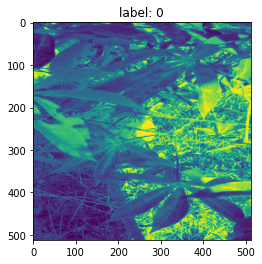

In [23]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# Bi-tempered logistic loss

In [24]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

# MODEL

In [25]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        if hasattr(self.model, 'classifier'):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG['target_size'])
        elif hasattr(self.model, 'fc'):
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG['target_size'])

    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
model = CustomModel(model_name=TAG['model_name'], pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[-0.0845,  0.0595, -0.0645, -0.0349, -0.0264],
        [ 0.2884, -0.0738,  0.1081, -0.1811,  0.6432],
        [ 0.0400,  0.0571, -0.1134, -0.0362,  0.1600],
        [-0.1190,  0.0642, -0.0481, -0.0280, -0.0417]],
       grad_fn=<AddmmBackward>)


# Helper functions

In [27]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))




In [28]:
# ====================================================
# loss
# ====================================================
def get_loss(criterion, y_preds, labels):
    if TAG['criterion']=='CrossEntropyLoss':
        loss = criterion(y_preds, labels)
    elif TAG['criterion'] == 'bi_tempered_logistic_loss':
        loss = criterion(y_preds, labels, t1=CFG['bi_tempered_loss_t1'], t2=CFG['bi_tempered_loss_t2'])
    return loss

In [29]:
# ====================================================
# Helper functions
# ====================================================
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        r = np.random.rand(1)
        is_aug = r < 0.5    # probability of augmentation
        if is_aug & ('cutmix' in TAG['augmentation']):
            # generate mixed sample
            # inference from https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
            lam = np.random.beta(CFG['CutmixAlpha'], CFG['CutmixAlpha'])
            rand_index = torch.randperm(images.size()[0]).to(device)
            labels_a = labels
            labels_b = labels[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
            # adjust lambda to exactly match pixel ratio
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
            # compute output
            y_preds = model(images)
            loss = get_loss(criterion, y_preds, labels_a) * lam + \
                    get_loss(criterion, y_preds, labels_b) * (1. - lam)
        else:
            y_preds = model(images)
            loss = get_loss(criterion, y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG['gradient_accumulation_steps'] > 1:
            loss = loss / CFG['gradient_accumulation_steps']
        if CFG['apex']:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        # clear memory
        del loss, y_preds
        torch.cuda.empty_cache()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG['max_grad_norm'])
        if (step + 1) % CFG['gradient_accumulation_steps'] == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG['print_freq'] == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = get_loss(criterion, y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG['gradient_accumulation_steps'] > 1:
            loss = loss / CFG['gradient_accumulation_steps']
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG['print_freq'] == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            # model.load_state_dict(state['model'])
            model.load_state_dict(state)
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [30]:
# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if TAG['scheduler']=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG['factor'], patience=CFG['patience'], verbose=True, eps=CFG['eps'])
    elif TAG['scheduler']=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG['T_max'], eta_min=CFG['min_lr'], last_epoch=-1)
    elif TAG['scheduler']=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
    return scheduler

# ====================================================
# criterion
# ====================================================
def get_criterion():
    if TAG['criterion']=='CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif TAG['criterion'] == 'bi_tempered_logistic_loss':
        criterion = bi_tempered_logistic_loss
    return criterion

In [31]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")
    if not CFG['debug']:
        mlflow.set_tag('running.fold', str(fold))
    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG['batch_size'], 
                              shuffle=True, 
                              num_workers=CFG['num_workers'], pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG['batch_size'], 
                              shuffle=False, 
                              num_workers=CFG['num_workers'], pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer & criterion
    # ====================================================
    best_model_path = OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth'
    latest_model_path = OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_latest.pth'

    model = CustomModel(TAG['model_name'], pretrained=True)
    model.to(device)
    # 学習途中の重みがあれば読み込み
    if os.path.isfile(latest_model_path):
        state_latest = torch.load(latest_model_path)
        state_best = torch.load(best_model_path)
        model.load_state_dict(state_latest['model'])
        epoch_start = state_latest['epoch']+1
        # er_best_score = state_latest['score']
        er_counter = state_latest['counter']
        er_best_score = state_best['best_score']

        LOGGER.info(f'Load training model in epoch:{epoch_start}, best_score:{er_best_score:.3f}, counter:{er_counter}')

    # 学習済みモデルを再学習する場合
    elif os.path.isfile(best_model_path):
        state_best = torch.load(best_model_path)
        model.load_state_dict(state_best['model'])
        epoch_start = 0 # epochは0からカウントしなおす
        er_counter = 0
        er_best_score = state_best['best_score']

        LOGGER.info(f'Retrain model, best_score:{er_best_score:.3f}')
    else:
        epoch_start = 0
        er_best_score = None
        er_counter = 0

    optimizer = Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'], amsgrad=False)
    scheduler = get_scheduler(optimizer)
    criterion = get_criterion()

    # ====================================================
    # apex
    # ====================================================
    if CFG['apex']:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    # best_score = 0.
    # best_loss = np.inf
    early_stopping = EarlyStopping(
                            patience=CFG['early_stopping_round'], 
                            verbose=True,
                            save_path=best_model_path,
                            counter=er_counter, best_score=er_best_score, 
                            save_latest_path=latest_model_path)
    
    for epoch in range(epoch_start, CFG['epochs']):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG['target_col']].values
        
        # early stopping
        early_stopping(avg_val_loss, model, preds, epoch)
        if early_stopping.early_stop:
            print(f'Epoch {epoch+1} - early stopping')
            break
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        # log mlflow
        if not CFG['debug']:
            mlflow.log_metric(f"fold{fold} avg_train_loss", avg_loss, step=epoch)
            mlflow.log_metric(f"fold{fold} avg_valid_loss", avg_val_loss, step=epoch)
            mlflow.log_metric(f"fold{fold} score", score, step=epoch)
            mlflow.log_metric(f"fold{fold} lr", scheduler.get_last_lr()[0], step=epoch)
            mlflow.log_artifact(best_model_path)
            if os.path.isfile(latest_model_path):
                mlflow.log_artifact(latest_model_path)
    
    check_point = torch.load(best_model_path)
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [32]:
def get_trained_fold_preds(folds, fold, best_model_path):
    val_idx = folds[folds['fold'] == fold].index
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    check_point = torch.load(best_model_path)
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds


def save_confusion_matrix(oof):
    from sklearn.metrics import confusion_matrix
    cm_ = confusion_matrix(oof['label'], oof['preds'], labels=[0,1,2,3,4])
    label_name = ['0 (CBB)', '1 (CBSD)', '2 (CGM)', '3 (CMD)', '4 (Healthy)']
    cm = pd.DataFrame(cm_, index=label_name, columns=label_name)
    cm.to_csv(OUTPUT_DIR+'oof_confusion_matrix.csv', index=True)


def copy_pretrained_model():
    folder_path = f'{INFO["SHARE_DRIVE_PATH"]}/{TAG["retrain_model"]}'
    pretrainted_paths = glob.glob(f'{folder_path}/*best.pth')
    for pretrainted_path in pretrainted_paths:
        # bestとしてコピー
        file_name = pretrainted_path.split('/')[-1]
        shutil.copy2(pretrainted_path, f'{OUTPUT_DIR}/{file_name}')

In [33]:
# ====================================================
# main
# ====================================================
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG['target_col']].values
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.5f}')
    
    return score

    

def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """
    
    if CFG['train']:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG['n_fold']):
            best_model_path = OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth'
            if fold in CFG['trn_fold']:
                _oof_df = train_loop(folds, fold)
            elif os.path.exists(best_model_path):
                _oof_df = get_trained_fold_preds(folds, fold, best_model_path)
            else:
                _oof_df = None
            if _oof_df is not None:
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                _ = get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        score = get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        save_confusion_matrix(oof_df)
        # log mlflow
        if not CFG['debug']:
            mlflow.log_metric('oof score', score)
            mlflow.delete_tag('running.fold')
            mlflow.log_artifact(OUTPUT_DIR+'oof_df.csv')
    
    if CFG['inference']:
        # inference
        model = CustomModel(TAG['model_name'], pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth') for fold in CFG['trn_fold']]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG['batch_size'], shuffle=False, 
                                 num_workers=CFG['num_workers'], pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

# rerun

In [34]:
def _load_save_point(run_id):
    # どこで中断したか取得
    stop_fold = int(mlflow.get_run(run_id=run_id).to_dictionary()['data']['tags']['running.fold'])
    # 学習対象のfoldを変更
    CFG['trn_fold'] = [fold for fold in CFG['trn_fold'] if fold>=stop_fold]
    # 学習済みモデルがあれば.pthファイルを取得(学習中も含む)
    client = mlflow.tracking.MlflowClient()
    artifacts = [artifact for artifact in client.list_artifacts(run_id) if ".pth" in artifact.path]
    for artifact in artifacts:
        client.download_artifacts(run_id, artifact.path, OUTPUT_DIR)


def check_have_run():
    results = mlflow.search_runs(INFO['EXPERIMENT_ID'])
    run_id_list = results[results['tags.mlflow.runName']==TITLE]['run_id'].tolist()
    # 初めて実行する場合
    if len(run_id_list) == 0:
        run_id = None
    # 既に実行されている場合
    else:
        assert len(run_id_list)==1
        run_id = run_id_list[0]
        _load_save_point(run_id)

    return run_id

In [35]:
if __name__ == '__main__':
    if CFG['debug']:
        # 他の学習済みモデルを再学習する
        if 'retrain_model' in TAG.keys():
            copy_pretrained_model()
        main()
    else:
        mlflow.set_tracking_uri(INFO['TRACKING_URI'])
        mlflow.set_experiment('single model')
        # 他の学習済みモデルを再学習する
        if 'retrain_model' in TAG.keys():
            copy_pretrained_model()
        # 既に実行済みの場合は続きから実行する
        run_id = check_have_run()
        with mlflow.start_run(run_id=run_id, run_name=TITLE):
            if run_id is None:
                mlflow.log_artifact(CONFIG_PATH)
                mlflow.log_param('device', device)
                mlflow.set_tag('env', env)
                mlflow.set_tags(TAG)
                mlflow.log_params(CFG)
            mlflow.log_artifact(notebook_path)
            main()
            mlflow.log_artifacts(OUTPUT_DIR)
            remove_glob(f'{OUTPUT_DIR}/*latest.pth')
            if env=="kaggle":
                shutil.copy2(CONFIG_PATH, f'{OUTPUT_DIR}/{CONFIG_NAME}')
                ! rm -r cassava
            elif env=="colab":
                shutil.copytree(OUTPUT_DIR, f'{INFO["SHARE_DRIVE_PATH"]}/{TITLE}')
                shutil.copy2(CONFIG_PATH, f'{INFO["SHARE_DRIVE_PATH"]}/{TITLE}/{CONFIG_NAME}')

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth
Load training model in epoch:1, best_score:-0.096, counter:1


Epoch: [2][0/1069] Data 2.078 (2.078) Elapsed 0m 3s (remain 66m 7s) Loss: 0.0630(0.0630) Grad: 0.8790  
Epoch: [2][100/1069] Data 0.000 (0.021) Elapsed 1m 47s (remain 17m 12s) Loss: 0.2847(0.0973) Grad: 1.4680  
Epoch: [2][200/1069] Data 0.000 (0.011) Elapsed 3m 31s (remain 15m 14s) Loss: 0.1623(0.0952) Grad: 1.2770  
Epoch: [2][300/1069] Data 0.000 (0.007) Elapsed 5m 16s (remain 13m 26s) Loss: 0.0086(0.0904) Grad: 0.2866  
Epoch: [2][400/1069] Data 0.000 (0.005) Elapsed 7m 0s (remain 11m 39s) Loss: 0.1061(0.0947) Grad: 0.9972  
Epoch: [2][500/1069] Data 0.000 (0.004) Elapsed 8m 44s (remain 9m 54s) Loss: 0.0838(0.0953) Grad: 0.2369  
Epoch: [2][600/1069] Data 0.000 (0.004) Elapsed 10m 28s (remain 8m 9s) Loss: 0.0995(0.0966) Grad: 0.9398  
Epoch: [2][700/1069] Data 0.000 (0.003) Elapsed 12m 12s (remain 6m 24s) Loss: 0.1489(0.0975) Grad: 0.3138  
Epoch: [2][800/1069] Data 0.000 (0.003) Elapsed 13m 56s (remain 4m 39s) Loss: 0.1211(0.0980) Grad: 1.0937  
Epoch: [2][900/1069] Data 0.000 (0.

Epoch 2 - avg_train_loss: 0.0987  avg_val_loss: 0.1085  time: 1183s
Epoch 2 - Accuracy: 0.8794392523364486


EarlyStopping counter: 2 out of 5
Epoch: [3][0/1069] Data 1.634 (1.634) Elapsed 0m 3s (remain 54m 48s) Loss: 0.1721(0.1721) Grad: 1.1227  
Epoch: [3][100/1069] Data 0.000 (0.016) Elapsed 1m 47s (remain 17m 8s) Loss: 0.0511(0.0970) Grad: 0.9000  
Epoch: [3][200/1069] Data 0.000 (0.008) Elapsed 3m 31s (remain 15m 13s) Loss: 0.2652(0.0964) Grad: 0.8981  
Epoch: [3][300/1069] Data 0.000 (0.006) Elapsed 5m 15s (remain 13m 26s) Loss: 0.0555(0.0953) Grad: 0.2741  
Epoch: [3][400/1069] Data 0.000 (0.004) Elapsed 7m 0s (remain 11m 39s) Loss: 0.0806(0.0952) Grad: 0.0672  
Epoch: [3][500/1069] Data 0.000 (0.003) Elapsed 8m 44s (remain 9m 54s) Loss: 0.0908(0.0946) Grad: 0.6944  
Epoch: [3][600/1069] Data 0.000 (0.003) Elapsed 10m 29s (remain 8m 9s) Loss: 0.0968(0.0938) Grad: 1.1224  
Epoch: [3][700/1069] Data 0.000 (0.002) Elapsed 12m 13s (remain 6m 25s) Loss: 0.1645(0.0949) Grad: 0.6408  
Epoch: [3][800/1069] Data 0.000 (0.002) Elapsed 13m 57s (remain 4m 40s) Loss: 0.1260(0.0953) Grad: 0.6879  
E

Epoch 3 - avg_train_loss: 0.0946  avg_val_loss: 0.1097  time: 1184s
Epoch 3 - Accuracy: 0.8799065420560748


EarlyStopping counter: 3 out of 5
Epoch: [4][0/1069] Data 1.679 (1.679) Elapsed 0m 3s (remain 55m 20s) Loss: 0.0467(0.0467) Grad: 1.0586  
Epoch: [4][100/1069] Data 0.000 (0.017) Elapsed 1m 47s (remain 17m 9s) Loss: 0.0975(0.0947) Grad: 0.7448  
Epoch: [4][200/1069] Data 0.000 (0.009) Elapsed 3m 31s (remain 15m 13s) Loss: 0.0299(0.0953) Grad: 0.6793  
Epoch: [4][300/1069] Data 0.000 (0.006) Elapsed 5m 15s (remain 13m 25s) Loss: 0.0140(0.0962) Grad: 0.4590  
Epoch: [4][400/1069] Data 0.000 (0.004) Elapsed 7m 0s (remain 11m 39s) Loss: 0.0876(0.0927) Grad: 1.1392  
Epoch: [4][500/1069] Data 0.000 (0.004) Elapsed 8m 44s (remain 9m 54s) Loss: 0.2427(0.0929) Grad: 1.0194  
Epoch: [4][600/1069] Data 0.000 (0.003) Elapsed 10m 28s (remain 8m 9s) Loss: 0.0858(0.0927) Grad: 0.9089  
Epoch: [4][700/1069] Data 0.000 (0.003) Elapsed 12m 12s (remain 6m 24s) Loss: 0.0542(0.0916) Grad: 0.7789  
Epoch: [4][800/1069] Data 0.000 (0.002) Elapsed 13m 56s (remain 4m 40s) Loss: 0.0901(0.0914) Grad: 0.2499  
E

Epoch 4 - avg_train_loss: 0.0909  avg_val_loss: 0.1042  time: 1182s
Epoch 4 - Accuracy: 0.8885514018691589


EarlyStopping counter: 4 out of 5
Epoch: [5][0/1069] Data 1.452 (1.452) Elapsed 0m 2s (remain 52m 57s) Loss: 0.0884(0.0884) Grad: 0.8753  
Epoch: [5][100/1069] Data 0.000 (0.015) Elapsed 1m 47s (remain 17m 6s) Loss: 0.1071(0.0823) Grad: 0.8103  
Epoch: [5][200/1069] Data 0.000 (0.007) Elapsed 3m 31s (remain 15m 12s) Loss: 0.1115(0.0826) Grad: 0.6064  
Epoch: [5][300/1069] Data 0.000 (0.005) Elapsed 5m 15s (remain 13m 25s) Loss: 0.0063(0.0876) Grad: 0.2112  
Epoch: [5][400/1069] Data 0.000 (0.004) Elapsed 6m 59s (remain 11m 39s) Loss: 0.0730(0.0867) Grad: 1.0855  
Epoch: [5][500/1069] Data 0.000 (0.003) Elapsed 8m 44s (remain 9m 54s) Loss: 0.0730(0.0872) Grad: 1.1745  
Epoch: [5][600/1069] Data 0.000 (0.003) Elapsed 10m 28s (remain 8m 9s) Loss: 0.0330(0.0852) Grad: 0.6112  
Epoch: [5][700/1069] Data 0.000 (0.002) Elapsed 12m 12s (remain 6m 24s) Loss: 0.0883(0.0860) Grad: 0.9933  
Epoch: [5][800/1069] Data 0.000 (0.002) Elapsed 13m 57s (remain 4m 40s) Loss: 0.0637(0.0868) Grad: 0.8593  


========== fold: 0 result ==========
Score: 0.89603
========== fold: 1 training ==========


EarlyStopping counter: 5 out of 5
Epoch 5 - early stopping


Load training model in epoch:1, best_score:-0.093, counter:1


Epoch: [2][0/1069] Data 1.348 (1.348) Elapsed 0m 3s (remain 54m 48s) Loss: 0.0925(0.0925) Grad: 1.0125  
Epoch: [2][100/1069] Data 0.000 (0.014) Elapsed 1m 46s (remain 17m 4s) Loss: 0.1481(0.0945) Grad: 0.6575  
Epoch: [2][200/1069] Data 0.000 (0.007) Elapsed 3m 30s (remain 15m 9s) Loss: 0.1036(0.0932) Grad: 0.4537  
Epoch: [2][300/1069] Data 0.000 (0.005) Elapsed 5m 14s (remain 13m 21s) Loss: 0.0628(0.0984) Grad: 0.5521  
Epoch: [2][400/1069] Data 0.000 (0.004) Elapsed 6m 57s (remain 11m 36s) Loss: 0.0141(0.0996) Grad: 0.4049  
Epoch: [2][500/1069] Data 0.000 (0.003) Elapsed 8m 41s (remain 9m 51s) Loss: 0.0966(0.0991) Grad: 1.0147  
Epoch: [2][600/1069] Data 0.000 (0.002) Elapsed 10m 25s (remain 8m 6s) Loss: 0.0362(0.0981) Grad: 0.6943  
Epoch: [2][700/1069] Data 0.000 (0.002) Elapsed 12m 8s (remain 6m 22s) Loss: 0.1265(0.0987) Grad: 0.9982  
Epoch: [2][800/1069] Data 0.000 (0.002) Elapsed 13m 52s (remain 4m 38s) Loss: 0.1366(0.1002) Grad: 0.9363  
Epoch: [2][900/1069] Data 0.000 (0.0

Epoch 2 - avg_train_loss: 0.1005  avg_val_loss: 0.1008  time: 1175s
Epoch 2 - Accuracy: 0.8939252336448598


EarlyStopping counter: 2 out of 5
Epoch: [3][0/1069] Data 1.443 (1.443) Elapsed 0m 2s (remain 52m 29s) Loss: 0.0287(0.0287) Grad: 0.3689  
Epoch: [3][100/1069] Data 0.000 (0.014) Elapsed 1m 46s (remain 17m 1s) Loss: 0.0250(0.0914) Grad: 0.6763  
Epoch: [3][200/1069] Data 0.000 (0.007) Elapsed 3m 30s (remain 15m 7s) Loss: 0.1735(0.0956) Grad: 1.0817  
Epoch: [3][300/1069] Data 0.000 (0.005) Elapsed 5m 13s (remain 13m 20s) Loss: 0.2299(0.0993) Grad: 0.7410  
Epoch: [3][400/1069] Data 0.000 (0.004) Elapsed 6m 57s (remain 11m 35s) Loss: 0.1504(0.0986) Grad: 0.8500  
Epoch: [3][500/1069] Data 0.000 (0.003) Elapsed 8m 41s (remain 9m 50s) Loss: 0.0932(0.1004) Grad: 0.6693  
Epoch: [3][600/1069] Data 0.000 (0.003) Elapsed 10m 24s (remain 8m 6s) Loss: 0.0815(0.0988) Grad: 0.7266  
Epoch: [3][700/1069] Data 0.000 (0.002) Elapsed 12m 8s (remain 6m 22s) Loss: 0.1641(0.0993) Grad: 1.0296  
Epoch: [3][800/1069] Data 0.000 (0.002) Elapsed 13m 52s (remain 4m 38s) Loss: 0.1733(0.0980) Grad: 1.0897  
Ep

Epoch 3 - avg_train_loss: 0.0986  avg_val_loss: 0.1053  time: 1175s
Epoch 3 - Accuracy: 0.8852803738317757


EarlyStopping counter: 3 out of 5
Epoch: [4][0/1069] Data 1.510 (1.510) Elapsed 0m 2s (remain 53m 4s) Loss: 0.1077(0.1077) Grad: 0.5882  
Epoch: [4][100/1069] Data 0.000 (0.015) Elapsed 1m 46s (remain 17m 1s) Loss: 0.1283(0.0885) Grad: 1.1693  
Epoch: [4][200/1069] Data 0.000 (0.008) Elapsed 3m 30s (remain 15m 7s) Loss: 0.0142(0.0951) Grad: 0.4049  
Epoch: [4][300/1069] Data 0.000 (0.005) Elapsed 5m 13s (remain 13m 20s) Loss: 0.0886(0.0957) Grad: 0.9167  
Epoch: [4][400/1069] Data 0.000 (0.004) Elapsed 6m 57s (remain 11m 35s) Loss: 0.0667(0.0933) Grad: 1.1741  
Epoch: [4][500/1069] Data 0.000 (0.003) Elapsed 8m 40s (remain 9m 50s) Loss: 0.1304(0.0945) Grad: 0.9232  
Epoch: [4][600/1069] Data 0.000 (0.003) Elapsed 10m 24s (remain 8m 6s) Loss: 0.1101(0.0957) Grad: 0.5627  
Epoch: [4][700/1069] Data 0.000 (0.002) Elapsed 12m 8s (remain 6m 22s) Loss: 0.0729(0.0944) Grad: 0.9278  
Epoch: [4][800/1069] Data 0.000 (0.002) Elapsed 13m 51s (remain 4m 38s) Loss: 0.0039(0.0931) Grad: 0.1578  
Epo

Epoch 4 - avg_train_loss: 0.0935  avg_val_loss: 0.0994  time: 1175s
Epoch 4 - Accuracy: 0.8925233644859814


EarlyStopping counter: 4 out of 5
Epoch: [5][0/1069] Data 1.191 (1.191) Elapsed 0m 2s (remain 51m 30s) Loss: 0.0183(0.0183) Grad: 0.4158  
Epoch: [5][100/1069] Data 0.000 (0.012) Elapsed 1m 46s (remain 17m 1s) Loss: 0.0660(0.0781) Grad: 0.3321  
Epoch: [5][200/1069] Data 0.000 (0.006) Elapsed 3m 30s (remain 15m 8s) Loss: 0.1334(0.0826) Grad: 1.5696  
Epoch: [5][300/1069] Data 0.000 (0.004) Elapsed 5m 13s (remain 13m 21s) Loss: 0.1684(0.0854) Grad: 1.2097  
Epoch: [5][400/1069] Data 0.000 (0.003) Elapsed 6m 57s (remain 11m 35s) Loss: 0.1085(0.0857) Grad: 0.8337  
Epoch: [5][500/1069] Data 0.000 (0.003) Elapsed 8m 41s (remain 9m 50s) Loss: 0.2292(0.0856) Grad: 0.4834  
Epoch: [5][600/1069] Data 0.000 (0.002) Elapsed 10m 24s (remain 8m 6s) Loss: 0.2100(0.0864) Grad: 1.3273  
Epoch: [5][700/1069] Data 0.000 (0.002) Elapsed 12m 8s (remain 6m 22s) Loss: 0.1989(0.0865) Grad: 1.3772  
Epoch: [5][800/1069] Data 0.000 (0.002) Elapsed 13m 52s (remain 4m 38s) Loss: 0.0744(0.0885) Grad: 0.7301  
Ep

========== fold: 1 result ==========
Score: 0.89860
========== fold: 2 training ==========


EarlyStopping counter: 5 out of 5
Epoch 5 - early stopping


Load training model in epoch:1, best_score:-0.096, counter:1


Epoch: [2][0/1069] Data 1.585 (1.585) Elapsed 0m 3s (remain 55m 47s) Loss: 0.1322(0.1322) Grad: 0.9029  
Epoch: [2][100/1069] Data 0.000 (0.016) Elapsed 1m 46s (remain 17m 3s) Loss: 0.0270(0.0820) Grad: 0.7066  
Epoch: [2][200/1069] Data 0.000 (0.008) Elapsed 3m 30s (remain 15m 8s) Loss: 0.1760(0.0915) Grad: 1.0294  
Epoch: [2][300/1069] Data 0.000 (0.005) Elapsed 5m 14s (remain 13m 21s) Loss: 0.0420(0.0907) Grad: 0.7234  
Epoch: [2][400/1069] Data 0.000 (0.004) Elapsed 6m 57s (remain 11m 36s) Loss: 0.0166(0.0919) Grad: 0.4385  
Epoch: [2][500/1069] Data 0.000 (0.003) Elapsed 8m 41s (remain 9m 51s) Loss: 0.0726(0.0935) Grad: 0.5956  
Epoch: [2][600/1069] Data 0.000 (0.003) Elapsed 10m 25s (remain 8m 7s) Loss: 0.0252(0.0933) Grad: 0.7093  
Epoch: [2][700/1069] Data 0.000 (0.002) Elapsed 12m 8s (remain 6m 22s) Loss: 0.0057(0.0951) Grad: 0.1626  
Epoch: [2][800/1069] Data 0.000 (0.002) Elapsed 13m 52s (remain 4m 38s) Loss: 0.0840(0.0952) Grad: 0.8789  
Epoch: [2][900/1069] Data 0.000 (0.0

Epoch 2 - avg_train_loss: 0.0987  avg_val_loss: 0.1054  time: 1176s
Epoch 2 - Accuracy: 0.8840850666043468


EarlyStopping counter: 2 out of 5
Epoch: [3][0/1069] Data 1.636 (1.636) Elapsed 0m 3s (remain 53m 25s) Loss: 0.0139(0.0139) Grad: 0.4706  
Epoch: [3][100/1069] Data 0.000 (0.016) Elapsed 1m 46s (remain 17m 3s) Loss: 0.1019(0.0894) Grad: 0.7031  
Epoch: [3][200/1069] Data 0.000 (0.008) Elapsed 3m 30s (remain 15m 8s) Loss: 0.1036(0.0913) Grad: 1.0788  
Epoch: [3][300/1069] Data 0.000 (0.006) Elapsed 5m 14s (remain 13m 21s) Loss: 0.0704(0.0922) Grad: 0.3954  
Epoch: [3][400/1069] Data 0.000 (0.004) Elapsed 6m 57s (remain 11m 35s) Loss: 0.0310(0.0917) Grad: 0.6320  
Epoch: [3][500/1069] Data 0.000 (0.003) Elapsed 8m 41s (remain 9m 51s) Loss: 0.1182(0.0916) Grad: 1.3464  
Epoch: [3][600/1069] Data 0.000 (0.003) Elapsed 10m 25s (remain 8m 6s) Loss: 0.1383(0.0914) Grad: 1.0257  
Epoch: [3][700/1069] Data 0.000 (0.002) Elapsed 12m 8s (remain 6m 22s) Loss: 0.0832(0.0923) Grad: 0.6301  
Epoch: [3][800/1069] Data 0.000 (0.002) Elapsed 13m 52s (remain 4m 38s) Loss: 0.0692(0.0931) Grad: 1.0226  
Ep

Epoch 3 - avg_train_loss: 0.0943  avg_val_loss: 0.1069  time: 1176s
Epoch 3 - Accuracy: 0.881280673054452


EarlyStopping counter: 3 out of 5
Epoch: [4][0/1069] Data 1.518 (1.518) Elapsed 0m 2s (remain 52m 31s) Loss: 0.0681(0.0681) Grad: 0.5759  
Epoch: [4][100/1069] Data 0.000 (0.015) Elapsed 1m 46s (remain 17m 3s) Loss: 0.0133(0.0894) Grad: 0.4268  
Epoch: [4][200/1069] Data 0.000 (0.008) Elapsed 3m 30s (remain 15m 8s) Loss: 0.0912(0.0893) Grad: 1.1270  
Epoch: [4][300/1069] Data 0.000 (0.005) Elapsed 5m 14s (remain 13m 21s) Loss: 0.0208(0.0900) Grad: 0.8840  
Epoch: [4][400/1069] Data 0.000 (0.004) Elapsed 6m 57s (remain 11m 36s) Loss: 0.1327(0.0907) Grad: 1.0291  
Epoch: [4][500/1069] Data 0.000 (0.003) Elapsed 8m 41s (remain 9m 51s) Loss: 0.0139(0.0903) Grad: 0.2861  
Epoch: [4][600/1069] Data 0.000 (0.003) Elapsed 10m 25s (remain 8m 6s) Loss: 0.0310(0.0896) Grad: 0.6381  
Epoch: [4][700/1069] Data 0.000 (0.002) Elapsed 12m 9s (remain 6m 22s) Loss: 0.0575(0.0893) Grad: 0.8058  
Epoch: [4][800/1069] Data 0.000 (0.002) Elapsed 13m 52s (remain 4m 38s) Loss: 0.1603(0.0901) Grad: 1.4168  
Ep

Epoch 4 - avg_train_loss: 0.0903  avg_val_loss: 0.1047  time: 1176s
Epoch 4 - Accuracy: 0.8838513671418555


EarlyStopping counter: 4 out of 5
Epoch: [5][0/1069] Data 1.410 (1.410) Elapsed 0m 2s (remain 52m 8s) Loss: 0.1559(0.1559) Grad: 0.1968  
Epoch: [5][100/1069] Data 0.000 (0.014) Elapsed 1m 46s (remain 17m 1s) Loss: 0.0668(0.0942) Grad: 1.0726  
Epoch: [5][200/1069] Data 0.000 (0.007) Elapsed 3m 30s (remain 15m 8s) Loss: 0.0639(0.0907) Grad: 1.1643  
Epoch: [5][300/1069] Data 0.000 (0.005) Elapsed 5m 13s (remain 13m 21s) Loss: 0.0177(0.0898) Grad: 0.5271  
Epoch: [5][400/1069] Data 0.000 (0.004) Elapsed 6m 57s (remain 11m 35s) Loss: 0.0809(0.0870) Grad: 1.2733  
Epoch: [5][500/1069] Data 0.000 (0.003) Elapsed 8m 41s (remain 9m 50s) Loss: 0.0510(0.0868) Grad: 0.1907  
Epoch: [5][600/1069] Data 0.000 (0.003) Elapsed 10m 24s (remain 8m 6s) Loss: 0.1406(0.0864) Grad: 0.9617  
Epoch: [5][700/1069] Data 0.000 (0.002) Elapsed 12m 8s (remain 6m 22s) Loss: 0.1153(0.0850) Grad: 1.0025  
Epoch: [5][800/1069] Data 0.000 (0.002) Elapsed 13m 52s (remain 4m 38s) Loss: 0.1023(0.0857) Grad: 1.0370  
Epo

========== fold: 2 result ==========
Score: 0.89367
========== fold: 3 training ==========


EarlyStopping counter: 5 out of 5
Epoch 5 - early stopping


Load training model in epoch:1, best_score:-0.101, counter:1


Epoch: [2][0/1069] Data 1.437 (1.437) Elapsed 0m 3s (remain 54m 58s) Loss: 0.0660(0.0660) Grad: 0.4187  
Epoch: [2][100/1069] Data 0.000 (0.014) Elapsed 1m 46s (remain 17m 5s) Loss: 0.0707(0.0905) Grad: 0.3510  
Epoch: [2][200/1069] Data 0.000 (0.007) Elapsed 3m 30s (remain 15m 10s) Loss: 0.0628(0.0930) Grad: 0.4111  
Epoch: [2][300/1069] Data 0.000 (0.005) Elapsed 5m 14s (remain 13m 23s) Loss: 0.1055(0.0934) Grad: 0.7618  
Epoch: [2][400/1069] Data 0.000 (0.004) Elapsed 6m 58s (remain 11m 37s) Loss: 0.0664(0.0937) Grad: 0.9268  
Epoch: [2][500/1069] Data 0.000 (0.003) Elapsed 8m 42s (remain 9m 52s) Loss: 0.1013(0.0933) Grad: 0.6819  
Epoch: [2][600/1069] Data 0.000 (0.003) Elapsed 10m 26s (remain 8m 7s) Loss: 0.0523(0.0954) Grad: 0.7110  
Epoch: [2][700/1069] Data 0.000 (0.002) Elapsed 12m 10s (remain 6m 23s) Loss: 0.1294(0.0968) Grad: 1.0586  
Epoch: [2][800/1069] Data 0.000 (0.002) Elapsed 13m 54s (remain 4m 39s) Loss: 0.0971(0.0975) Grad: 0.9188  
Epoch: [2][900/1069] Data 0.000 (0

Epoch 2 - avg_train_loss: 0.0975  avg_val_loss: 0.1068  time: 1178s
Epoch 2 - Accuracy: 0.8831502687543819


EarlyStopping counter: 2 out of 5
Epoch: [3][0/1069] Data 1.695 (1.695) Elapsed 0m 3s (remain 54m 11s) Loss: 0.0204(0.0204) Grad: 0.6147  
Epoch: [3][100/1069] Data 0.000 (0.017) Elapsed 1m 47s (remain 17m 5s) Loss: 0.0396(0.0959) Grad: 0.9159  
Epoch: [3][200/1069] Data 0.000 (0.009) Elapsed 3m 31s (remain 15m 11s) Loss: 0.0617(0.0956) Grad: 0.3734  
Epoch: [3][300/1069] Data 0.000 (0.006) Elapsed 5m 15s (remain 13m 23s) Loss: 0.0621(0.0924) Grad: 1.3352  
Epoch: [3][400/1069] Data 0.000 (0.004) Elapsed 6m 59s (remain 11m 38s) Loss: 0.1202(0.0906) Grad: 1.2386  
Epoch: [3][500/1069] Data 0.000 (0.004) Elapsed 8m 43s (remain 9m 53s) Loss: 0.3315(0.0938) Grad: 1.1676  
Epoch: [3][600/1069] Data 0.000 (0.003) Elapsed 10m 27s (remain 8m 8s) Loss: 0.0402(0.0934) Grad: 0.6496  
Epoch: [3][700/1069] Data 0.000 (0.003) Elapsed 12m 11s (remain 6m 23s) Loss: 0.1020(0.0925) Grad: 1.0785  
Epoch: [3][800/1069] Data 0.000 (0.002) Elapsed 13m 55s (remain 4m 39s) Loss: 0.0472(0.0943) Grad: 0.9901  


Epoch 3 - avg_train_loss: 0.0946  avg_val_loss: 0.1081  time: 1181s
Epoch 3 - Accuracy: 0.8838513671418555


EarlyStopping counter: 3 out of 5
Epoch: [4][0/1069] Data 1.540 (1.540) Elapsed 0m 3s (remain 53m 38s) Loss: 0.0802(0.0802) Grad: 0.5009  
Epoch: [4][100/1069] Data 0.000 (0.015) Elapsed 1m 47s (remain 17m 7s) Loss: 0.1708(0.0894) Grad: 1.3264  
Epoch: [4][200/1069] Data 0.000 (0.008) Elapsed 3m 31s (remain 15m 14s) Loss: 0.1484(0.0905) Grad: 1.5387  
Epoch: [4][300/1069] Data 0.000 (0.005) Elapsed 5m 16s (remain 13m 26s) Loss: 0.1344(0.0897) Grad: 1.0971  
Epoch: [4][400/1069] Data 0.000 (0.004) Elapsed 7m 0s (remain 11m 40s) Loss: 0.0292(0.0867) Grad: 0.7092  
Epoch: [4][500/1069] Data 0.000 (0.003) Elapsed 8m 45s (remain 9m 55s) Loss: 0.1377(0.0882) Grad: 0.6978  
Epoch: [4][600/1069] Data 0.000 (0.003) Elapsed 10m 29s (remain 8m 10s) Loss: 0.0942(0.0891) Grad: 0.9107  
Epoch: [4][700/1069] Data 0.000 (0.002) Elapsed 12m 13s (remain 6m 25s) Loss: 0.1062(0.0892) Grad: 1.3578  
Epoch: [4][800/1069] Data 0.000 (0.002) Elapsed 13m 58s (remain 4m 40s) Loss: 0.1466(0.0887) Grad: 1.5816  


Epoch 4 - avg_train_loss: 0.0898  avg_val_loss: 0.1155  time: 1186s
Epoch 4 - Accuracy: 0.8742696891797149


EarlyStopping counter: 4 out of 5
Epoch: [5][0/1069] Data 1.542 (1.542) Elapsed 0m 3s (remain 54m 56s) Loss: 0.0738(0.0738) Grad: 0.7913  
Epoch: [5][100/1069] Data 0.000 (0.015) Elapsed 1m 47s (remain 17m 8s) Loss: 0.1215(0.0890) Grad: 0.9238  
Epoch: [5][200/1069] Data 0.000 (0.008) Elapsed 3m 31s (remain 15m 14s) Loss: 0.0614(0.0824) Grad: 0.9985  
Epoch: [5][300/1069] Data 0.000 (0.005) Elapsed 5m 16s (remain 13m 26s) Loss: 0.0261(0.0877) Grad: 0.6203  
Epoch: [5][400/1069] Data 0.000 (0.004) Elapsed 7m 0s (remain 11m 40s) Loss: 0.1130(0.0864) Grad: 0.7689  
Epoch: [5][500/1069] Data 0.000 (0.003) Elapsed 8m 45s (remain 9m 55s) Loss: 0.0119(0.0853) Grad: 0.4942  
Epoch: [5][600/1069] Data 0.000 (0.003) Elapsed 10m 29s (remain 8m 9s) Loss: 0.1050(0.0882) Grad: 0.8610  
Epoch: [5][700/1069] Data 0.000 (0.002) Elapsed 12m 13s (remain 6m 25s) Loss: 0.0073(0.0882) Grad: 0.2810  
Epoch: [5][800/1069] Data 0.000 (0.002) Elapsed 13m 57s (remain 4m 40s) Loss: 0.0567(0.0867) Grad: 0.6617  
E

========== fold: 3 result ==========
Score: 0.88502
========== fold: 4 training ==========


EarlyStopping counter: 5 out of 5
Epoch 5 - early stopping


Retrain model, best_score:-0.103


Epoch: [1][0/1069] Data 1.084 (1.084) Elapsed 0m 2s (remain 52m 56s) Loss: 0.1443(0.1443) Grad: 0.9438  
Epoch: [1][100/1069] Data 0.000 (0.011) Elapsed 1m 45s (remain 16m 47s) Loss: 0.0093(0.0993) Grad: 0.3424  
Epoch: [1][200/1069] Data 0.000 (0.006) Elapsed 3m 27s (remain 14m 55s) Loss: 0.1290(0.0980) Grad: 0.7283  
Epoch: [1][300/1069] Data 0.000 (0.004) Elapsed 5m 9s (remain 13m 10s) Loss: 0.0214(0.0952) Grad: 0.5003  
Epoch: [1][400/1069] Data 0.000 (0.003) Elapsed 6m 52s (remain 11m 26s) Loss: 0.0640(0.0951) Grad: 0.8430  
Epoch: [1][500/1069] Data 0.000 (0.002) Elapsed 8m 34s (remain 9m 43s) Loss: 0.0597(0.0948) Grad: 0.9429  
Epoch: [1][600/1069] Data 0.000 (0.002) Elapsed 10m 16s (remain 8m 0s) Loss: 0.0856(0.0943) Grad: 1.0749  
Epoch: [1][700/1069] Data 0.000 (0.002) Elapsed 11m 59s (remain 6m 17s) Loss: 0.0873(0.0949) Grad: 0.8214  
Epoch: [1][800/1069] Data 0.000 (0.002) Elapsed 13m 41s (remain 4m 34s) Loss: 0.1195(0.0938) Grad: 0.7489  
Epoch: [1][900/1069] Data 0.000 (0

Epoch 1 - avg_train_loss: 0.0940  avg_val_loss: 0.1100  time: 1162s
Epoch 1 - Accuracy: 0.8819817714419257


EarlyStopping counter: 1 out of 5
Epoch: [2][0/1069] Data 1.493 (1.493) Elapsed 0m 3s (remain 54m 19s) Loss: 0.0177(0.0177) Grad: 0.3983  
Epoch: [2][100/1069] Data 0.000 (0.015) Elapsed 1m 45s (remain 16m 49s) Loss: 0.0701(0.0948) Grad: 0.6019  
Epoch: [2][200/1069] Data 0.000 (0.008) Elapsed 3m 27s (remain 14m 56s) Loss: 0.0576(0.0891) Grad: 0.9423  
Epoch: [2][300/1069] Data 0.000 (0.005) Elapsed 5m 9s (remain 13m 10s) Loss: 0.1801(0.0865) Grad: 1.0124  
Epoch: [2][400/1069] Data 0.000 (0.004) Elapsed 6m 52s (remain 11m 26s) Loss: 0.0297(0.0891) Grad: 0.5660  
Epoch: [2][500/1069] Data 0.000 (0.003) Elapsed 8m 34s (remain 9m 43s) Loss: 0.1519(0.0906) Grad: 0.9782  
Epoch: [2][600/1069] Data 0.000 (0.003) Elapsed 10m 16s (remain 8m 0s) Loss: 0.0990(0.0913) Grad: 0.7432  
Epoch: [2][700/1069] Data 0.000 (0.002) Elapsed 11m 58s (remain 6m 17s) Loss: 0.0569(0.0908) Grad: 1.1830  
Epoch: [2][800/1069] Data 0.000 (0.002) Elapsed 13m 40s (remain 4m 34s) Loss: 0.2386(0.0904) Grad: 0.9150  


Epoch 2 - avg_train_loss: 0.0895  avg_val_loss: 0.1296  time: 1162s
Epoch 2 - Accuracy: 0.859546623042767


EarlyStopping counter: 2 out of 5
Epoch: [3][0/1069] Data 1.918 (1.918) Elapsed 0m 3s (remain 63m 57s) Loss: 0.1205(0.1205) Grad: 0.8278  
Epoch: [3][100/1069] Data 0.000 (0.019) Elapsed 1m 45s (remain 16m 54s) Loss: 0.0752(0.0782) Grad: 0.2609  
Epoch: [3][200/1069] Data 0.000 (0.010) Elapsed 3m 28s (remain 14m 58s) Loss: 0.0077(0.0802) Grad: 0.2772  
Epoch: [3][300/1069] Data 0.000 (0.007) Elapsed 5m 10s (remain 13m 12s) Loss: 0.1772(0.0833) Grad: 1.2334  
Epoch: [3][400/1069] Data 0.000 (0.005) Elapsed 6m 52s (remain 11m 27s) Loss: 0.1006(0.0835) Grad: 1.2906  
Epoch: [3][500/1069] Data 0.000 (0.004) Elapsed 8m 35s (remain 9m 43s) Loss: 0.1404(0.0836) Grad: 0.3260  
Epoch: [3][600/1069] Data 0.000 (0.003) Elapsed 10m 17s (remain 8m 0s) Loss: 0.0929(0.0844) Grad: 0.5991  
Epoch: [3][700/1069] Data 0.000 (0.003) Elapsed 11m 59s (remain 6m 17s) Loss: 0.1050(0.0856) Grad: 1.2626  
Epoch: [3][800/1069] Data 0.000 (0.003) Elapsed 13m 41s (remain 4m 34s) Loss: 0.0940(0.0857) Grad: 1.0853  

Epoch 3 - avg_train_loss: 0.0873  avg_val_loss: 0.1132  time: 1163s
Epoch 3 - Accuracy: 0.8761392848796448


EarlyStopping counter: 3 out of 5
Epoch: [4][0/1069] Data 1.353 (1.353) Elapsed 0m 3s (remain 54m 6s) Loss: 0.1686(0.1686) Grad: 0.7746  
Epoch: [4][100/1069] Data 0.000 (0.014) Elapsed 1m 45s (remain 16m 49s) Loss: 0.1192(0.0745) Grad: 0.7060  
Epoch: [4][200/1069] Data 0.000 (0.007) Elapsed 3m 27s (remain 14m 56s) Loss: 0.0488(0.0808) Grad: 0.8447  
Epoch: [4][300/1069] Data 0.000 (0.005) Elapsed 5m 9s (remain 13m 10s) Loss: 0.0032(0.0772) Grad: 0.1292  
Epoch: [4][400/1069] Data 0.000 (0.004) Elapsed 6m 52s (remain 11m 26s) Loss: 0.0257(0.0754) Grad: 0.5468  
Epoch: [4][500/1069] Data 0.000 (0.003) Elapsed 8m 34s (remain 9m 43s) Loss: 0.1846(0.0778) Grad: 1.1552  
Epoch: [4][600/1069] Data 0.000 (0.002) Elapsed 10m 16s (remain 8m 0s) Loss: 0.0206(0.0780) Grad: 0.6068  
Epoch: [4][700/1069] Data 0.000 (0.002) Elapsed 11m 58s (remain 6m 17s) Loss: 0.1960(0.0794) Grad: 1.1120  
Epoch: [4][800/1069] Data 0.000 (0.002) Elapsed 13m 40s (remain 4m 34s) Loss: 0.1612(0.0791) Grad: 0.9407  
E

Epoch 4 - avg_train_loss: 0.0811  avg_val_loss: 0.1218  time: 1161s
Epoch 4 - Accuracy: 0.867492404767469


EarlyStopping counter: 4 out of 5
Epoch: [5][0/1069] Data 1.263 (1.263) Elapsed 0m 2s (remain 52m 49s) Loss: 0.0221(0.0221) Grad: 0.6841  
Epoch: [5][100/1069] Data 0.000 (0.013) Elapsed 1m 45s (remain 16m 47s) Loss: 0.2026(0.0715) Grad: 0.9125  
Epoch: [5][200/1069] Data 0.000 (0.006) Elapsed 3m 27s (remain 14m 55s) Loss: 0.1628(0.0764) Grad: 0.8644  
Epoch: [5][300/1069] Data 0.000 (0.004) Elapsed 5m 9s (remain 13m 9s) Loss: 0.1017(0.0782) Grad: 1.1078  
Epoch: [5][400/1069] Data 0.000 (0.003) Elapsed 6m 51s (remain 11m 25s) Loss: 0.1241(0.0761) Grad: 1.4447  
Epoch: [5][500/1069] Data 0.000 (0.003) Elapsed 8m 33s (remain 9m 42s) Loss: 0.0344(0.0752) Grad: 0.5793  
Epoch: [5][600/1069] Data 0.000 (0.002) Elapsed 10m 16s (remain 7m 59s) Loss: 0.0560(0.0750) Grad: 1.0229  
Epoch: [5][700/1069] Data 0.000 (0.002) Elapsed 11m 58s (remain 6m 17s) Loss: 0.0081(0.0755) Grad: 0.2925  
Epoch: [5][800/1069] Data 0.000 (0.002) Elapsed 13m 40s (remain 4m 34s) Loss: 0.0218(0.0749) Grad: 1.2459  


========== fold: 4 result ==========
Score: 0.88432
========== CV ==========
Score: 0.89153


EarlyStopping counter: 5 out of 5
Epoch 5 - early stopping
